In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.optimize import basinhopping, dual_annealing
from IPython.display import display, clear_output

"""
helper functions
"""
# euler to transformation matrix
def Euler_matrix(abg,xyz):
    cv0 = np.cos(abg[0])
    sv0 = np.sin(abg[0]) 
    cv1 = np.cos(abg[1]) 
    sv1 = np.sin(abg[1]) 
    cv2 = np.cos(abg[2])
    sv2 = np.sin(abg[2])
    return np.matrix([
        [cv1* cv0   , sv2*sv1*cv0 - cv2*sv0 , cv2*sv1*cv0 - sv2*sv0 , xyz[0]  ],
        [cv1 * sv0  , sv2*sv1*sv0 + cv2*cv0 , cv2*sv1*sv0 + sv2*cv0 , xyz[1]  ],
        [-sv1       , sv2*cv1               , cv2*cv1               , xyz[2]  ],
        [0,0,0,1]])


"""
j0_true = j0 + p[6]
j1_true = j1 + p[7]
j2_true = j2 + p[8]
j3_true = j3 + p[9]
j4_true = j4 + p[10]
"""
"""
def likelihood_2(p, kinematic, data, use_aruco):
    total_error = 0
    
    T_cam_2_j4 = np.matrix([[ 0, -1,  0, p[0]],
                            [ 1, 0, 0, p[1]],
                            [ 0, 0, 1, p[2]],
                            [ 0, 0, 0, 1]])
    num_data = 0

    for point_set in data:
        v =[]
        for idx in range(len(point_set)):
            gt = []
            if use_aruco:
                gt = point_set[idx]["aruco_t_target_2_cam"]
            else:
                gt = point_set[idx]["t_target_2_cam"]

            joint = np.array(point_set[idx]["joint"])+np.array([p[6],p[7],p[8],p[9],p[10], 0])
            
            g = np.matmul(np.matmul(kinematic.Ti_r_world(i=5, joint=joint), np.matrix(T_cam_2_j4)), 
                np.vstack((np.reshape(gt, (3,1) ), np.array([[1]]))))
            v.append([g[0,0],g[1,0],g[2,0]])
            num_data = num_data + 1
        

        centroid = None

        if len(p)>11:
            centroid = np.array([p[11], p[12], p[13]])
        else:
            centroid = np.mean(v, axis=0)

        a = np.array([np.linalg.norm(np.array(g) - np.array(centroid)) for g in v])
        total_error += np.linalg.norm(a)**2
    
    print("centroid: ", centroid)
    return np.sqrt(total_error/num_data)

def minimizer_2(data, robot, use_aruco=False, gt_estimate=None):
    
    # minimize
    bounds = [(robot.config["camera_mount"]["T"][0][3]-5, robot.config["camera_mount"]["T"][0][3]+5), (robot.config["camera_mount"]["T"][1][3]-5, robot.config["camera_mount"]["T"][1][3]+5), (robot.config["camera_mount"]["T"][2][3]-5, robot.config["camera_mount"]["T"][2][3]+5), 
            (np.pi/2-0.05, np.pi/2+0.05), (-0.05, 0.05), (-0.05, 0.05),
            (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)]
    x0 = [robot.config["camera_mount"]["T"][0][3],robot.config["camera_mount"]["T"][1][3],robot.config["camera_mount"]["T"][2][3],
        np.pi/2,0,0,
        0, 0, 0, 0, 0]
    if gt_estimate is not None:
        bounds += [(gt_estimate[i]-5, gt_estimate[i]+5) for i in range(len(gt_estimate))]
        x0 += gt_estimate

    f = minimize(likelihood, x0=x0, args = (robot.kinematic, data, use_aruco), bounds=bounds, method='L-BFGS-B', options={'tol': 1e-6})    

    T_cam_2_j4 = Euler_matrix([f.x[3],f.x[4],f.x[5]],[f.x[0],f.x[1],f.x[2]])
    joint_error = [f.x[6],f.x[7],f.x[8],f.x[9],f.x[10]]
    centroid = None
    if len(f.x)>11:
        centroid = [f.x[11], f.x[12], f.x[13]]
    
    return T_cam_2_j4, joint_error, centroid, f.fun
"""

def likelihood(p, kinematic, data, use_aruco, use_ground_truth):
    total_error = 0
    
    T_cam_2_j4 = Euler_matrix([p[3],p[4],p[5]],[p[0],p[1],p[2]])
    num_data = 0

    for point_set in data:
        v =[]
        for idx in range(len(point_set)):
            gt = []
            if use_aruco:
                gt = point_set[idx]["aruco_t_target_2_cam"]
            else:
                gt = point_set[idx]["t_target_2_cam"]

            joint = np.array(point_set[idx]["joint"])+np.array([p[6],p[7],p[8],p[9],p[10], 0])
            
            g = np.matmul(np.matmul(kinematic.Ti_r_world(i=5, joint=joint), np.matrix(T_cam_2_j4)), 
                np.vstack((np.reshape(gt, (3,1) ), np.array([[1]]))))
            v.append([g[0,0],g[1,0],g[2,0]])
            num_data = num_data + 1
        

        centroid = None

        if len(point_set[0]["t_target_2_base"])==0:
            centroid = np.mean(v, axis=0)
        else:
            if len(p)>11:
                centroid = np.array([p[11], p[12], p[13]])
            else:
                if(use_ground_truth):
                    centroid =  point_set[0]["t_target_2_base"]
                else:
                    centroid = np.mean(v, axis=0)

        a = np.array([np.linalg.norm(np.array(g) - np.array(centroid)) for g in v])
        total_error += np.linalg.norm(a)**2
    
    print("centroid: ", centroid)
    return np.sqrt(total_error/num_data)


def validation(T_cam_2_j4, data, kinematic, gt):
    error_list = []
    for d in data:
        g = np.matmul(np.matmul(kinematic.Ti_r_world(i=5, joint=d["joint"]), np.matrix(T_cam_2_j4)), 
            np.vstack((np.reshape(d["t_target_2_cam"], (3,1) ), np.array([[1]]))))
        detected = np.array([g[0,0],g[1,0],g[2,0]])
        #error_list.append(np.linalg.norm(np.array(detected) - np.array(gt)))
        error_list.append(np.array(detected) - np.array(gt))
    return error_list


def minimizer(data, kinematic, use_aruco=False, use_ground_truth=True, gt_estimate=None):
    
    # minimize
    bounds = [(40, 55), (25, 35), (-6, 6), (np.pi/2, np.pi/2), (0, 0), (0, 0), (-1, 1), (-1, 1), (-1, 1), (-1, 1), (-1, 1)]
    #bounds = [(40, 55), (25, 35), (-6, 6), (np.pi/2-0.01, np.pi/2+0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01)]
    x0 = [45,30,-2,np.pi/2,0,0, 0, 0, 0, 0, 0]
    if gt_estimate is not None:
        bounds += [(gt_estimate[i]-5, gt_estimate[i]+5) for i in range(len(gt_estimate))]
        x0 += gt_estimate

    f = minimize(likelihood, x0=x0, args = (kinematic, data, use_aruco, use_ground_truth), bounds=bounds, method='L-BFGS-B', options={'maxiter': 50, 'tol': 1e-1})    
    #f = differential_evolution(likelihood, bounds, args=(kinematic, data, use_aruco, use_ground_truth), tol=1e-1, workers=-1, maxiter=1)
    """
    f = basinhopping(
        likelihood,
        x0,
        niter=2,
        stepsize=0.1,
        minimizer_kwargs={
            "method": "L-BFGS-B",  # or another appropriate method
            "args": (kinematic, data, use_aruco, use_ground_truth),
            "options": {"disp": True, "maxiter": 2}  # Enable display for the local minimizer
        }
    )
    """
    """
    f = dual_annealing(
        likelihood,                      # The objective function
        bounds,                           # The bounds for each variable
        args=(kinematic, data, use_aruco, use_ground_truth),  # Additional arguments for the likelihood function
        maxiter=1,                      # Number of iterations
        initial_temp=5230,                 # Initial temperature (can be adjusted)
        visit=2.62,                        # Control how much to explore
        accept=-5.0,                       # Control how likely new points are accepted
    )
    """
    T_cam_2_j4 = Euler_matrix([f.x[3],f.x[4],f.x[5]],[f.x[0],f.x[1],f.x[2]])
    joint_error = [f.x[6],f.x[7],f.x[8],f.x[9],f.x[10]]
    centroid = None
    if len(f.x)>11:
        centroid = [f.x[11], f.x[12], f.x[13]]
    
    return T_cam_2_j4, joint_error, centroid, f.fun


def dorna_ta_eye_in_hand_camera_kit(robot, detection, joint_deviation, aruco_id):
    # init
    retval = []
    
    # record t_target_2_base
    touching = input("The robot is touching the aruco marker (y or n):")
    touching = touching.lower()

    # touch
    if touching != "y":
        return retval
    
    print("claibration process start")

    # init centroid
    xyz_target_2_base = robot.get_all_pose()[0:3]
    
    #go up
    robot.set_motor(1)
    robot.sleep(1)
    robot.lmove(rel=1, z=140, vel=100, accel=1000, jerk=2000)
    robot.jmove(rel=0, j0=-2.9042938990811535, j1=34.475098, j2=-109.973145, j3=0, j4=-16.501465, j5=0, vel=50, accel=800, jerk=1000)
    
    robot.sleep(1)
    
    # initial joint
    initial_joint = np.array(robot.get_all_joint()[0:6])
    target_joint_list = [(initial_joint +  joint).tolist() for joint in joint_deviation]

    initial_joint = np.array([-2.900391, 23.225098, -105.358887, 0, -9.865723, 0])
    target_joint_list += [(initial_joint +  joint).tolist() for joint in joint_deviation]

    """
    initial_joint = np.array([-2.900391, 20.43457, -103.820801, 0, -8.613281, 0])
    target_joint_list += [(initial_joint +  joint).tolist() for joint in joint_deviation]


    initial_joint = np.array([-2.724609, 22.148438, -98.085938, 0.021973, -16.062012, 0])
    target_joint_list += [(initial_joint +  joint).tolist() for joint in joint_deviation]

    initial_joint = np.array([-3.120117, 23.686523, -112.17041, -0.131836, -3.537598, 0])
    target_joint_list += [(initial_joint +  joint).tolist() for joint in joint_deviation]
    """
    pxl_target_2_cam_list = []
    # Generate all possible lists of size 5    
    for i in range(len(target_joint_list)):
        # move and sleep
        robot.jmove(rel=0, j0=target_joint_list[i][0], j1=target_joint_list[i][1], j2=target_joint_list[i][2], j3=target_joint_list[i][3], j4=target_joint_list[i][4], j5=target_joint_list[i][5])
        robot.sleep(0.2)

        # current joint
        joint = np.array(robot.get_all_joint()[0:6]).tolist()
        
        # run detection
        results = detection.run()
        if results:
            for result in results:
                if result["cls"] == str(int(aruco_id)) and result["xyz"][2] > 0:
                    # append collect data
                    retval.append({"joint": joint, "t_target_2_cam": result["xyz"], "t_target_2_base": xyz_target_2_base, "aruco_t_target_2_cam": result["tvec"], "aruco_r_target_2_cam": result["rvec"]})
                    pxl_target_2_cam_list.append(result["center"])
                    break
            
        # draw centers
        for pxl in pxl_target_2_cam_list:
            cv2.circle(detection.img, (int(pxl[0]), int(pxl[1])), 5, (255,0,255), 2)

        # Clear the previous output
        clear_output(wait=True)
        plt.imshow(cv2.cvtColor(detection.img, cv2.COLOR_BGR2RGB)) # Display the image
        plt.axis('off')  # Turn off axis
        display(plt.gcf())  # Display the updated plot
        plt.close() # release the memory
        print("round: ", i+1, " / ", len(target_joint_list))

    return retval


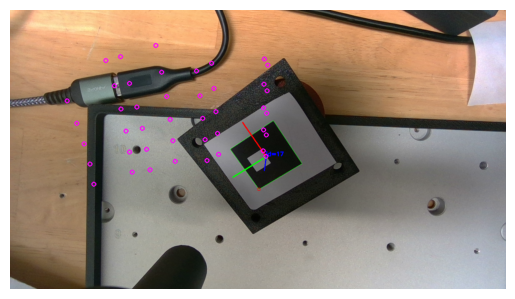

round:  48  /  48


In [ ]:
robot_ip = "192.168.254.87"
"""
necessary modules
"""
#%matplotlib widget
from dorna_vision import Detection, calibration
from camera import Camera
from dorna2 import Dorna
import numpy as np
import itertools

"""
System parameters
"""
robot_model = "dorna_ta" # robot model

"""
aruco board parameters
"""
aruco_id = 17 # detected marker
aruco_length= 25 # length in mm
aruco_dic="DICT_4X4_100" # aruco type
aruco_refine="CORNER_REFINE_APRILTAG"
aruco_subpix=False

# T
T = [[0.00525873615, -0.999894519, 0.0134620306, 46.5174596], [0.999959617, 0.00535678348, -0.0073579648, 32.0776662], [0.00728773209, -0.0135001806, 0.99988231, -4.24772615], [0.0, 0.0, 0.0, 1.0]] 
camera_gt = [317.03549462948905, -28.18051463666464, 0.3558355741266155]
# search area
joint_deviation = []
joint_deviation += list(itertools.product([-10, -5, 0, 5, ], [0], [0], [0], [-25, -20, -15, -10, -5, 0],[0]))
joint_deviation = np.array(joint_deviation)

# collected data
collected_data = []

# camera
camera = Camera()

# Robot
robot = Dorna()

for _ in range(1):
    if not camera.connect():
        print("can not connect to camera")
        break

    if not robot.connect(robot_ip):
        print("can not connect to robot")
        break

    print("camera connected")
    print("robot connected")
    # detection
    prm = {'detection': {'cmd': 'aruco', 'dictionary': aruco_dic, 'marker_length': aruco_length, 'refine': aruco_refine, 'subpix': aruco_subpix}}
    detection = Detection(camera=camera, robot=None, **prm)

    # update collected data
    collected_data.append(dorna_ta_eye_in_hand_camera_kit(robot, detection, joint_deviation, aruco_id))  

    # close the connections
    camera.close()
    robot.close()


In [3]:
"""
only one round from precalibrated camera
"""
from dorna2 import Dorna
robot = Dorna()
# from precalibrated camera
gt_estimate = [338.9252949765314, 23.68967314402868, 21.62377903450971]

# from minimizer
#gt_estimate =  [290.33413183, -21.79958878,  14.29851108] # 2z poistions

# from touch
#gt_estimate = [287.006871, -20.065185, 9.983926]

#gt_estimate=None

# transformation matrix
T_cam_2_j4, joint_error, centroid, error = minimizer(collected_data, robot.kinematic , use_aruco = False, use_ground_truth= False, gt_estimate=gt_estimate)

# print result
print(error)

centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377903]
centroid:  [338.92529499  23.68967314  21.62377903]
centroid:  [338.92529498  23.68967315  21.62377903]
centroid:  [338.92529498  23.68967314  21.62377904]
centroid:  [338.06323626  23.8328451   21.17646284]
centroid:  [338.06323626  23.8328451   21.17646284]
centroid:  [338.06323626  23.8328451   21.17646284]
centroid:  [338.06323626  23.8328451   21.17646284]
centroid:  [338.06323626  23.8328451   21.17646284]
centroid:  [338.06323626  23.8328451   21.17646284]
centroid:  [338.06323626  23.8328451   21.17646284]
centroid:  [

In [5]:
joint_error

[-0.22027600150961227,
 0.6424510254758161,
 -0.8775146445522464,
 -0.32692119735088965,
 -0.4406351478518776]

In [26]:
T_cam_2_j4

matrix([[ 6.12323400e-17, -1.00000000e+00,  0.00000000e+00,
          4.86666176e+01],
        [ 1.00000000e+00,  6.12323400e-17,  0.00000000e+00,
          3.04269504e+01],
        [-0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         -4.86378494e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])

In [5]:
import pickle
with open('data.pkl', 'wb') as file:
    pickle.dump(collected_data, file)


In [2]:
import pickle

# Load the pickle file
with open('data.pkl', 'rb') as file:  # Use 'rb' to read the file
    collected_data = pickle.load(file)
